# Chat Intents

## Topic Modeling

**Summary**

This notebook explores the possibilty of using topic modeling to extract intents from the 1,000 sample subset of the overall bank77 dataset. The scikit-learn and gensim implementations of LDA are investigated. Additionally, Correlation Explanation (https://github.com/gregversteeg/corex_topic), or CorEx, is also included in the analysis. As shown in the analysis below, one of the biggest challenges is identifying how many topics to include.

In order to avoid some package dependency conflicts, this notebook was created in a separate virtual environment than the rest of the notebooks and code in this repo. Before being able to run the below notebook, install gensim, pyLDAvis, and CorEx using:

`pip install gensim`

`pip install pyldavis`

`pip install corextopic`

In [140]:
%pip install gensim

%pip install pyldavis

%pip install corextopic

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
from corextopic import corextopic as ct

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [388]:
import pickle
product_asin='B018Y229OU'

with open(f'Reviews_{product_asin}.pkl', 'rb') as f:
    data_sample = pickle.load(f)

data_sample_positive=data_sample[data_sample.predef_sentiment=='positive']
data_sample_negative=data_sample[data_sample.predef_sentiment=='negative']
data_sample_neutral=data_sample[data_sample.predef_sentiment=='neutral']

In [389]:
X_positive = data_sample_positive['review']
X_negative = data_sample_negative['review']
X_neutral = data_sample_neutral['review']

In [390]:
print(X_positive, X_negative, X_neutral)

0        Good basic tablet for checking email , web browsing , and reading ebooks.
1                                                              I love this tablet.
2                                                              It was a great buy.
3                                            I would strongly recommend buying it.
4                           It's a great reader but also good for surfing the web.
                                           ...                                    
27593                I have bought 3 of these tablets for my great grand children.
27595                     Bought this for my four year old niece and she loves it.
27596                          Its exactly what I am wanted and the price was fair
27597                                    Awesome tablet it's fast and easy to use.
27598                               Affordable can't find any better at this price
Name: review, Length: 18416, dtype: object 54                                          

## LDA with Scikit-learn

In [42]:
count_vectorizer = CountVectorizer(ngram_range = (1, 2), max_df = 900, min_df = 10)

transformed_vector = count_vectorizer.fit_transform(X)
transformed_vector.shape

(2484, 822)

In [43]:
feature_names = count_vectorizer.get_feature_names_out()
feature_names[0:10]

array(['10', '15', '35', '50', 'able', 'able to', 'about', 'about it',
       'about the', 'access'], dtype=object)

In [44]:
%%time

perplexities = []
for NUM_TOPICS in range(3,20):
    lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)
    lda = lda_model.fit_transform(transformed_vector)
    perplexities.append(lda_model.perplexity(transformed_vector))

CPU times: user 2min 13s, sys: 8.14 ms, total: 2min 13s
Wall time: 2min 13s


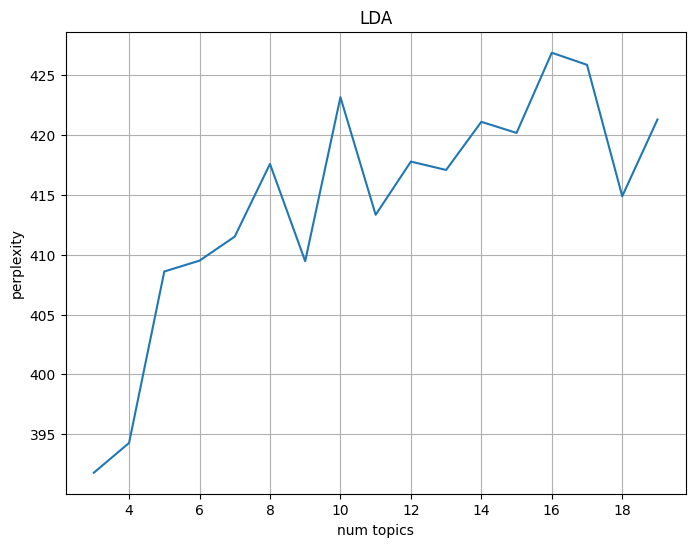

In [45]:
x = range(3, 20)
y = perplexities

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y)

ax.set(xlabel = 'num topics', ylabel = 'perplexity', title = 'LDA')
ax.grid()

plt.show()

In [46]:
%%time

scores = []
for NUM_TOPICS in range(3,20):
    lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)
    lda = lda_model.fit_transform(transformed_vector)
    scores.append(lda_model.score(transformed_vector))

CPU times: user 2min 15s, sys: 12.1 ms, total: 2min 15s
Wall time: 2min 15s


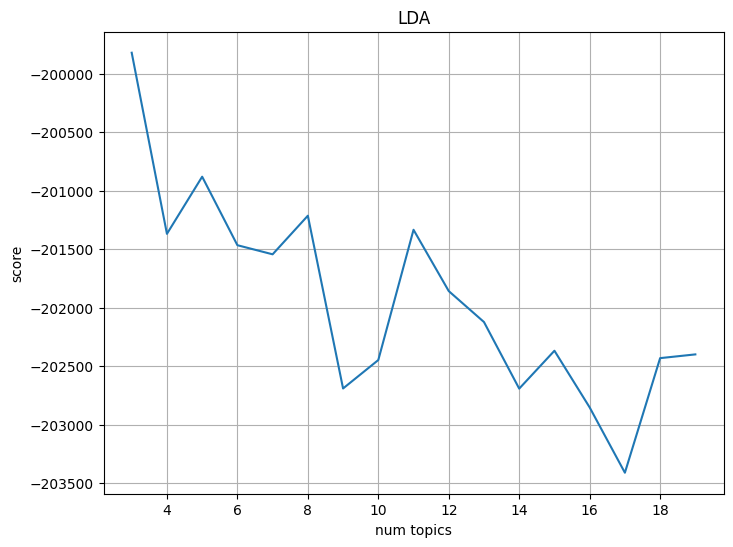

In [47]:
x = range(3, 20)
y = scores

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y)

ax.set(xlabel = 'num topics', ylabel = 'score', title = 'LDA')
ax.grid()

plt.show()

Some literature suggests that it might be possible to use perplexity (https://en.wikipedia.org/wiki/Perplexity)  to determine an optimal number of topics, but others have questioned relying on it. Regardless, the scikit-learn implementation appears to still have a bug(https://github.com/scikit-learn/scikit-learn/issues/6777) that makes the perplexity value unreliable. 

### Evaluate a fixed number of topics

In [48]:
NUM_TOPICS = 9

lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)

lda = lda_model.fit_transform(transformed_vector)
lda.shape

(2484, 9)

In [49]:
sum(lda[0])

1.0

In [50]:
lda_model.components_.shape

(9, 822)

In [51]:
lda_model.score(transformed_vector)

-201512.6861664963

In [52]:
def print_topic(identifier, top_words=10):
    for topic_id, topic_word_probs in enumerate(lda_model.components_):
        if topic_id == identifier:
            print(f"Topic {topic_id}: ")
            
            top_feature_names = [feature_names[i] for i in topic_word_probs.argsort()[: -top_words - 1: -1]]
            
            print(" ".join(top_feature_names))

In [53]:
for i in range(NUM_TOPICS):
    print_topic(i, top_words=10)

Topic 0: 
is only as it it is and slow is the the only very
Topic 1: 
to it have not and as does in does not ipad
Topic 2: 
that apps is amazon on app only google store are
Topic 3: 
to and this had with my it is amazon tablet
Topic 4: 
of not to it of the do work at all like
Topic 5: 
it to was be you can use and but with
Topic 6: 
to on screen ads they you like that don have
Topic 7: 
for was this my price tablet it and for the that
Topic 8: 
not is this but tablet you is not for good great


In [54]:
topics = []

for i in range(len(X)):
    topics.append(lda[i].argmax())

In [55]:
data_sample['topic'] = topics

data_sample.head()

,product,year,review,predef_sentiment,zc_sentiment,topic
54,B018Y229OU,2015,They haven't put them dwn willingly yet!,negative,negative,6
111,B018Y229OU,2016,Slow to use because there are constant popups.,negative,negative,5
112,B018Y229OU,2016,Barely dropped it 2 feet to the ground and now it doesn't work.,negative,negative,3
113,B018Y229OU,2016,Highly unsatisfied.,negative,negative,0
119,B018Y229OU,2016,Very slow if you want to stream videos though.,negative,negative,8


In [56]:
tsne = TSNE(n_components = 2, init = 'pca', random_state = 0)
lda_2d_tsne = tsne.fit_transform(lda)
lda_df_tsne = pd.DataFrame(lda_2d_tsne)
lda_df_tsne.shape

(2484, 2)

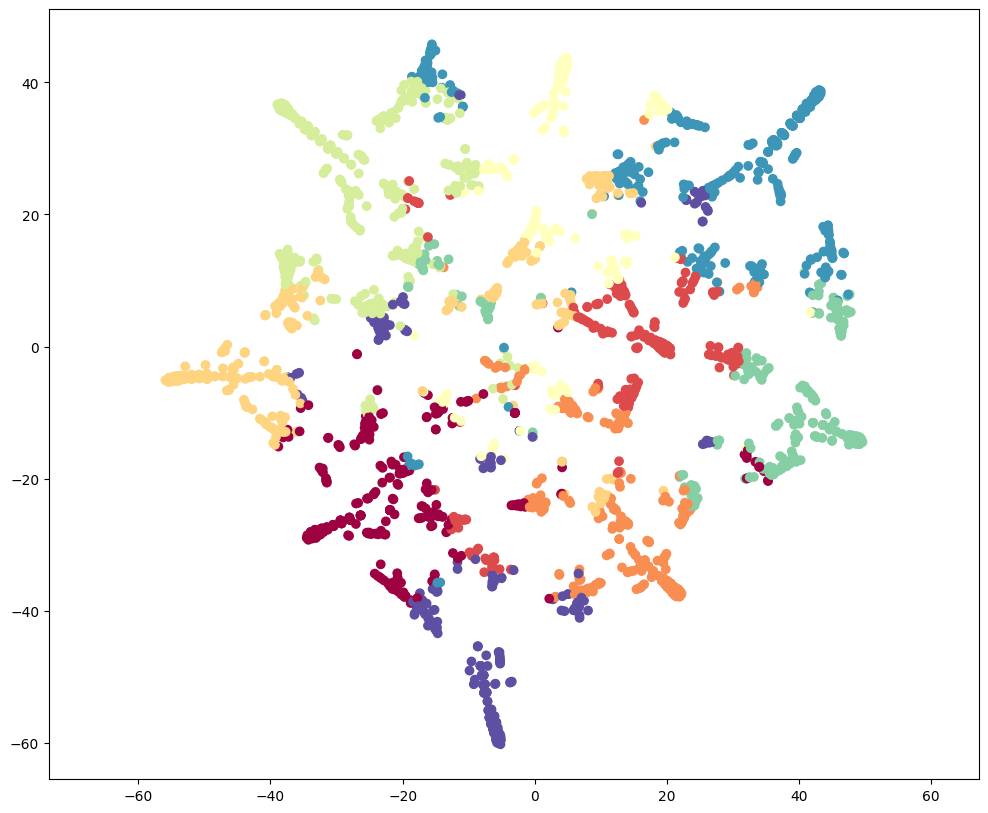

In [57]:
plt.subplots(figsize=(12, 10))
plt.axis('equal')

plt.scatter(lda_df_tsne[0], lda_df_tsne[1], c=data_sample['topic'], cmap = plt.cm.Spectral)

## LDA with Gensim

Gensim is a popular library for performing topic modeling and provides some additional functionality compared to the scikit-learn implementation.

In [58]:
all_messages = data_sample['review'].values.tolist()
all_tokens = [sent.split(' ') for sent in all_messages]

In [59]:
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram_phrases = Phrases(all_tokens, min_count=5)
bigram = Phraser(bigram_phrases)

for idx in range(len(all_tokens)):
    for token in bigram[all_tokens[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            all_tokens[idx].append(token)

In [60]:
bigram.phrasegrams

{'there_are': 15.56810035842294,
 'if_you': 29.897295012679628,
 'want_to': 11.101224105461393,
 'complaint_is': 16.000383548710687,
 'too_much': 35.26271186440678,
 'Bought_this': 21.242342342342344,
 'be_able': 19.207396546106224,
 'able_to': 17.49283798436341,
 'The_only': 32.28617886178861,
 'only_drawback': 25.55989159891599,
 'a_lot': 22.277966742252456,
 'I_bought': 12.248831168831169,
 'other_tablets.': 26.286510590858416,
 'at_times': 28.61529126213592,
 "I_don't": 14.175003955070402,
 "don't_like": 43.26223567726251,
 'bought_this': 16.736390936390936,
 'did_not': 17.8809403437816,
 'does_not': 24.103245591617686,
 'google_play': 104.79555555555555,
 'a_bit': 23.88956433637285,
 "I_didn't": 10.655233236151602,
 "didn't_want": 58.58136645962733,
 'pop_up': 36.38734567901234,
 'due_to': 15.858891579230562,
 'too_many': 48.73708143861099,
 "you_can't": 15.208126824631679,
 'at_all.': 101.74325782092771,
 'I_am': 17.376814058956917,
 'this_tablet': 10.233940972222221,
 'say_about

In [61]:
dictionary = Dictionary(all_tokens)

# filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.9)

# bag-of-words representation of the documents
corpus = [dictionary.doc2bow(text) for text in all_tokens]

In [62]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 567
Number of documents: 2484


Similar size corpus as the scikit-learn implementation above

### Iterate through different topic sizes

There are numerous coherence metrics, as outlined in the paper (http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf ) that the gensim implementation is based.


In [63]:
def compute_coherence_values(corpus, dictionary, num_topics):
    """
    Returns coherence of LDA model based for a given number of topics
    
    Arguments:
        corpus: list, of bag-of-words representation of each document
        dictionary: gensim dictionary oboject of document tokens
        num_topics: int, number of topics to model
    Returns:
        coherence: Cv coherence measure of topic model
    """
    
    # Set training parameters
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  
    
    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       chunksize=chunksize,
                                       alpha='auto',
                                       eta='auto',
                                       iterations=iterations,
                                       num_topics=num_topics,
                                       passes=passes,
                                       eval_every=eval_every
                                      )
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=all_tokens, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    
    coherence = coherence_model_lda.get_coherence()
    #perplexity = lda_model.log_perplexity(corpus)  
    
    return coherence

In [64]:
%%time

coherence_scores = []
#perplexity_scores = []
for NUM_TOPICS in range(3,20):
    coherence = compute_coherence_values(corpus, dictionary, NUM_TOPICS)
    coherence_scores.append(coherence)
    #perplexity_scores.append(perplexity)

CPU times: user 3min 13s, sys: 14.7 s, total: 3min 28s
Wall time: 3min 29s


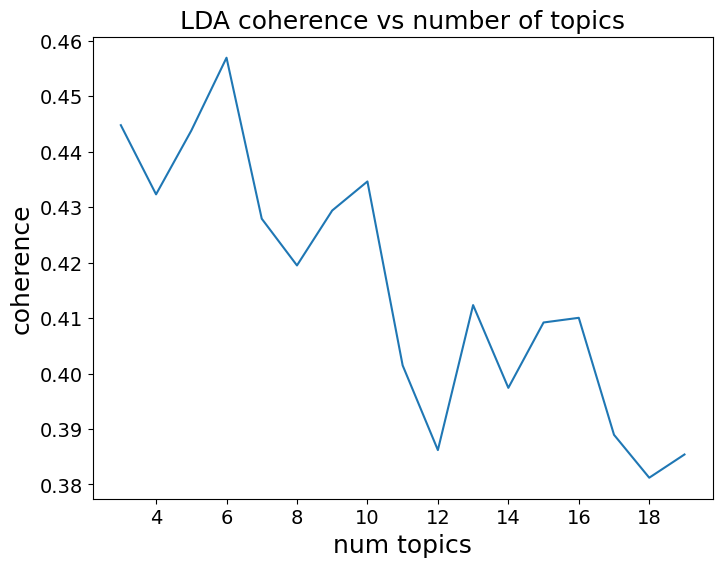

In [65]:
x = range(3, 20)
y = coherence_scores

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y)

plt.xlabel('num topics', fontsize=18)
plt.ylabel('coherence', fontsize=18)
plt.title('LDA coherence vs number of topics', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [68]:
plt.savefig('lda_coherence.png')

<Figure size 640x480 with 0 Axes>

In [108]:
list(range(3,20))[np.argmax(coherence_scores)]

6

#### Investigate 'optimal' topic number model

The maximum coherence value in the range searched appears to be 111. However, it seems like coherence will continue to increase with more topics. Additionally, 111 is already quite high. Instead, we'll pick an earlier max of ~17 topics as the 'right' number of topics.

In [109]:
# Set training parameters
num_topics = 6
chunksize = 2000
passes = 20
iterations = 400
eval_every = 5  

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [110]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -3.2511.
[([(0.074354865, 'I'),
   (0.057329062, 'to'),
   (0.037788127, 'the'),
   (0.03683632, 'it'),
   (0.025074601, 'a'),
   (0.024906972, 'and'),
   (0.020545155, 'for'),
   (0.020050686, 'was'),
   (0.019448137, 'that'),
   (0.015428566, 'this'),
   (0.014081465, 'my'),
   (0.01282025, 'with'),
   (0.012424045, 'had'),
   (0.011826144, 'have'),
   (0.01173096, 'so'),
   (0.011394716, 'but'),
   (0.01131378, 'not'),
   (0.008352231, 'of'),
   (0.008100174, 'on'),
   (0.007634351, 'do')],
  -1.9361724707599834),
 ([(0.059931654, 'is'),
   (0.058158133, 'the'),
   (0.042068236, 'you'),
   (0.032173768, 'to'),
   (0.027243916, 'that'),
   (0.026638215, 'it'),
   (0.02516019, 'only'),
   (0.024056233, 'and'),
   (0.022813668, 'The'),
   (0.020293163, 'on'),
   (0.015177112, 'with'),
   (0.013822271, 'apps'),
   (0.0123174265, 'The_only'),
   (0.012021822, 'in'),
   (0.010827432, 'of'),
   (0.0107967, 'can'),
   (0.01073718, 'not'),
   (0.010268963, 'get'),
  

In [111]:
topics = model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.060*"is" + 0.058*"the" + 0.042*"you" + 0.032*"to" + 0.027*"that"')
(1, '0.074*"I" + 0.057*"to" + 0.038*"the" + 0.037*"it" + 0.025*"a"')
(2, '0.095*"the" + 0.049*"of" + 0.033*"not" + 0.028*"a" + 0.027*"and"')
(3, '0.080*"a" + 0.034*"the" + 0.032*"little" + 0.031*"my" + 0.030*"of"')
(4, '0.049*"it" + 0.048*"to" + 0.048*"not" + 0.044*"is" + 0.039*"and"')
(5, '0.062*"is" + 0.054*"as" + 0.051*"not" + 0.046*"the" + 0.032*"to"')


In [112]:
# compute coherence score
coherence_model_lda = CoherenceModel(model=model, 
                                     texts=all_tokens, 
                                     dictionary=dictionary, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

print('\nPerplexity: ', model.log_perplexity(corpus))


Coherence Score:  0.3910966073456023

Perplexity:  -5.562664897187784


### Visualize the topics

pyLDAvis (https://github.com/bmabey/pyLDAvis) is a helpful tool for visualizing topics (although it doesn’t play nicely with Jupyter lab https://github.com/jupyterlab/jupyterlab/issues/7959) 

In [113]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.051082  0.067988       1        1  38.032143
0      0.076665  0.012734       2        1  23.749330
2      0.067257  0.110370       3        1  13.515420
5      0.183627 -0.090016       4        1  10.473588
3     -0.145827  0.105477       5        1   8.061564
4     -0.130641 -0.206553       6        1   6.167954, topic_info=              Term         Freq        Total Category  logprob  loglift
88               I   945.000000   945.000000  Default  30.0000  30.0000
34              is   811.000000   811.000000  Default  29.0000  29.0000
31               a   729.000000   729.000000  Default  28.0000  28.0000
15             the  1367.000000  1367.000000  Default  27.0000  27.0000
35             not   597.000000   597.000000  Default  26.0000  26.0000
8               to  1068.000000  1068.000000  Default  25.0000  25.0000
57              of   421.000000   421.000000  Default  24.0000  24.0000
71              as   222.000000   222.000000  Default  23.0000  23.0000
23             you   320.000000   320.000000  Default  22.0000  22.0000
13              it   717.000000   717.000000  Default  21.0000  21.0000
136           have   255.000000   255.000000  Default  20.0000  20.0000
25             for   519.000000   519.000000  Default  19.0000  19.0000
11             and   669.000000   669.000000  Default  18.0000  18.0000
137             my   262.000000   262.000000  Default  17.0000  17.0000
87            only   182.000000   182.000000  Default  16.0000  16.0000
55             but   356.000000   356.000000  Default  15.0000  15.0000
158         little    72.000000    72.000000  Default  14.0000  14.0000
48            This    85.000000    85.000000  Default  13.0000  13.0000
29             was   321.000000   321.000000  Default  12.0000  12.0000
30              It   140.000000   140.000000  Default  11.0000  11.0000
83             The   278.000000   278.000000  Default  10.0000  10.0000
4              are   163.000000   163.000000  Default   9.0000   9.0000
104             at   108.000000   108.000000  Default   8.0000   8.0000
276       a_little    54.000000    54.000000  Default   7.0000   7.0000
19            slow   104.000000   104.000000  Default   6.0000   6.0000
185         screen    99.000000    99.000000  Default   5.0000   5.0000
225           good    68.000000    68.000000  Default   4.0000   4.0000
12         doesn't    73.000000    73.000000  Default   3.0000   3.0000
108           apps   139.000000   139.000000  Default   2.0000   2.0000
141            Not    57.000000    57.000000  Default   1.0000   1.0000
21            want    45.509951    46.303000   Topic1  -5.4595   0.9495
145       wouldn't    42.890402    43.684338   Topic1  -5.5188   0.9484
176           I_am    39.510735    40.304364   Topic1  -5.6009   0.9469
363           I've    38.202444    38.999202   Topic1  -5.6345   0.9461
146       I_didn't    35.014095    35.809722   Topic1  -5.7217   0.9443
134          found    32.957165    33.752860   Topic1  -5.7822   0.9429
337       couldn't    28.466113    29.259558   Topic1  -5.9287   0.9392
280   disappointed    27.125421    27.934276   Topic1  -5.9770   0.9374
193           just    72.240418    74.433957   Topic1  -4.9974   0.9368
461      expensive    25.463839    26.259798   Topic1  -6.0402   0.9360
22         want_to    24.524294    25.317788   Topic1  -6.0778   0.9349
463             he    23.960657    24.755523   Topic1  -6.1010   0.9341
351           ads.    21.710341    22.507227   Topic1  -6.1996   0.9307
70           after    33.388723    34.644413   Topic1  -5.7692   0.9298
462           one.    21.142070    21.944673   Topic1  -6.2262   0.9295
2              put    20.402444    21.195298   Topic1  -6.2618   0.9286
148            had   132.861226   138.025336   Topic1  -4.3881   0.9286
558              5    20.026202    20.822642   Topic1  -6.2804   0.92

In [75]:
pyLDAvis.disable_notebook()

## Hierarchical Dirichlet Process

In [114]:
hdp = gensim.models.HdpModel(corpus, dictionary)

In [115]:
topic_info = hdp.print_topics(num_topics=-1, num_words=10)
len(topic_info)

0

In [116]:
len(hdp.get_topics())

150

In theory, the HDP algorithm is supposed to be able to automatically determine the number of topics in the data, but this dataset might be too small for it to be useful. See https://radimrehurek.com/gensim/models/hdpmodel.html for more details.

## CorEx

In [391]:
def extract_theme(keyword_string):
    keywords = keyword_string.split(", ")
    res = max(keywords, key = len)
    return(res)

In [392]:
tfidf_vectorizer = TfidfVectorizer(max_df = 1.0, 
                                   min_df = 5, 
                                   ngram_range = (1, 2)
                                  )

vectorizer_positive = tfidf_vectorizer.fit(X_positive)
tfidf_positive = vectorizer_positive.transform(X_positive)
vocab_positive = vectorizer_positive.get_feature_names_out()
print(len(vocab_positive))

6310


In [393]:
vectorizer_neutral = tfidf_vectorizer.fit(X_neutral)
tfidf_neutral = vectorizer_neutral.transform(X_neutral)
vocab_neutral = vectorizer_neutral.get_feature_names_out()
print(len(vocab_neutral))

3291


In [394]:
vectorizer_negative = tfidf_vectorizer.fit(X_negative)
tfidf_negative = vectorizer_negative.transform(X_negative)
vocab_negative = vectorizer_negative.get_feature_names_out()
print(len(vocab_negative))

1716


### Without anchor words

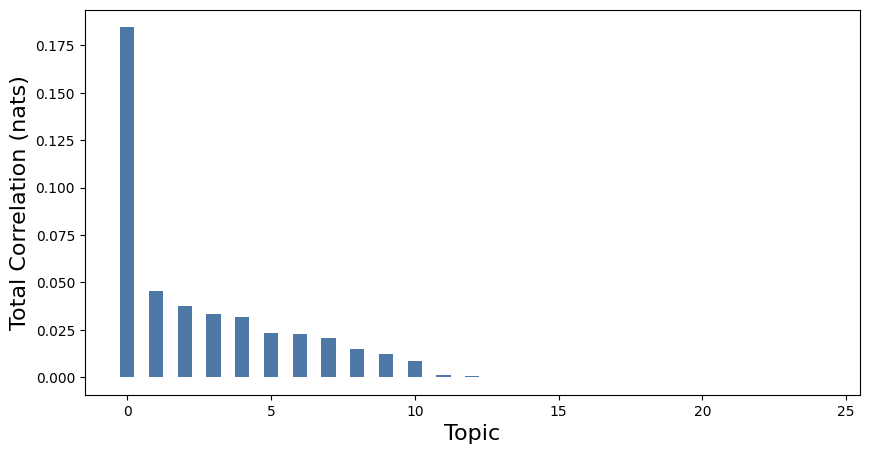

In [395]:
anchors = []
model = ct.Corex(n_hidden=25)
model = model.fit(tfidf_positive, words=vocab_positive)
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [396]:
topic_labels=[]
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print(f"Topic #{i+1}: {', '.join(topic_ngrams)}")
    topic_labels.append([i+1,', '.join(topic_ngrams)])

keywords_df_positive = pd.DataFrame(topic_labels, columns=['topic_num','keywords'])
keywords_df_positive['label'] = keywords_df_positive['keywords'].apply(lambda x: pd.Series(extract_theme(x)))
keywords_df_positive=keywords_df_positive[keywords_df_positive['label']!=''].reset_index()
keywords_df_positive

Topic #1: loves, loves it, for my, she loves, she, my, bought this, this for, he, bought
Topic #2: games, books, reading, web, movies, watch, playing, games and, watching, the web
Topic #3: love them, these, them, they, they love, of these, these for, and they, love, gifts
Topic #4: easy, easy to, to use, use, to, set up, very easy, set, to set, use and
Topic #5: recommend, would, would recommend, highly, recommend this, highly recommend, recommend it, to anyone, definitely recommend, anyone
Topic #6: battery life, battery, life, memory, sd, card, expandable, sd card, slot, storage
Topic #7: friday, black friday, black, beat, on black, can beat, go wrong, wrong, can go, can
Topic #8: does, does everything, everything, need, what, to do, it does, need it, the job, do
Topic #9: happy with, happy, very happy, with, am, purchase, pleased, pleased with, very pleased, with my
Topic #10: if you, if, you, prime, amazon prime, you have, you are, have amazon, prime member, an amazon
Topic #11: n

,index,topic_num,keywords,label
0,0,1,"loves, loves it, for my, she loves, she, my, bought this, this for, he, bought",bought this
1,1,2,"games, books, reading, web, movies, watch, playing, games and, watching, the web",games and
2,2,3,"love them, these, them, they, they love, of these, these for, and they, love, gifts",love them
3,3,4,"easy, easy to, to use, use, to, set up, very easy, set, to set, use and",very easy
4,4,5,"recommend, would, would recommend, highly, recommend this, highly recommend, recommend it, to anyone, definitely recommend, anyone",definitely recommend
5,5,6,"battery life, battery, life, memory, sd, card, expandable, sd card, slot, storage",battery life
6,6,7,"friday, black friday, black, beat, on black, can beat, go wrong, wrong, can go, can",black friday
7,7,8,"does, does everything, everything, need, what, to do, it does, need it, the job, do",does everything
8,8,9,"happy with, happy, very happy, with, am, purchase, pleased, pleased with, very pleased, with my",pleased with
9,9,10,"if you, if, you, prime, amazon prime, you have, you are, have amazon, prime member, an amazon",amazon prime


In [397]:
anchor_df = data_sample_positive.copy().reset_index()
new_boolean = model.transform(tfidf_positive)[:,list(keywords_df_positive.topic_num-1)]
labeled_df_positive = pd.DataFrame(columns=['product','year','year_str','review','sentiment','label_num','label'])

for idx_row,row in enumerate(new_boolean):
    for idx_col,col in enumerate(row):
        if col:
            labeled_df_positive.loc[len(labeled_df_positive.index)] = [anchor_df['product'][idx_row],anchor_df['year'][idx_row],str(anchor_df['year'][idx_row]),anchor_df['review'][idx_row],
                                                     anchor_df['predef_sentiment'][idx_row],keywords_df_positive['topic_num'][idx_col],keywords_df_positive['label'][idx_col]]

labeled_df_positive

,product,year,year_str,review,sentiment,label_num,label
0,B018Y229OU,2016,2016,"Good basic tablet for checking email , web browsing , and reading ebooks.",positive,2,games and
1,B018Y229OU,2016,2016,I would strongly recommend buying it.,positive,5,definitely recommend
2,B018Y229OU,2016,2016,It's a great reader but also good for surfing the web.,positive,2,games and
3,B018Y229OU,2016,2016,"Easy to set up and use, plus the price was reasonable.",positive,4,very easy
4,B018Y229OU,2016,2016,I got this for my niece.,positive,1,bought this
...,...,...,...,...,...,...,...
9432,B018Y229OU,2017,2017,He loves it.,positive,1,bought this
9433,B018Y229OU,2017,2017,I have bought 3 of these tablets for my great grand children.,positive,1,bought this
9434,B018Y229OU,2017,2017,I have bought 3 of these tablets for my great grand children.,positive,3,love them
9435,B018Y229OU,2017,2017,Bought this for my four year old niece and she loves it.,positive,1,bought this


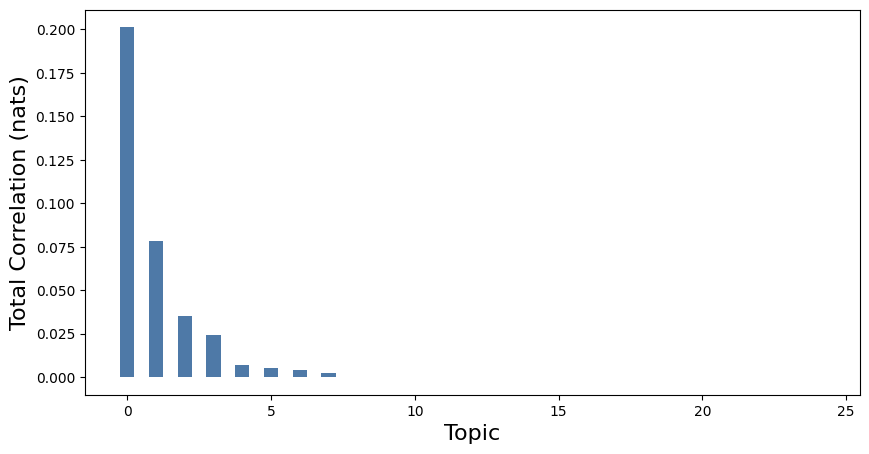

In [405]:
anchors = []
model = ct.Corex(n_hidden=25)
model = model.fit(tfidf_neutral, words=vocab_neutral)
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [406]:
topic_labels=[]
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print(f"Topic #{i+1}: {', '.join(topic_ngrams)}")
    topic_labels.append([i+1,', '.join(topic_ngrams)])

keywords_df_neutral = pd.DataFrame(topic_labels, columns=['topic_num','keywords'])
keywords_df_neutral['label'] = keywords_df_neutral['keywords'].apply(lambda x: pd.Series(extract_theme(x)))
keywords_df_neutral=keywords_df_neutral[keywords_df_neutral['label']!=''].reset_index()
keywords_df_neutral

Topic #1: for my, bought, old, my, year old, year, one for, bought this, for, gift
Topic #2: watch, games, movies, play games, read, books, to watch, play, videos, watch movies
Topic #3: friday, black friday, black, on black, sale, friday for, on sale, 35, this on, for 35
Topic #4: card, sd, you pay, pay for, what you, get what, memory, sd card, pay, you get
Topic #5: parental, easy, parental controls, controls, set, carry, easy to, small enough, easy for, to carry
Topic #6: does, job, the job, does the, it does, does everything, everything, gets the, does what, job done
Topic #7: beat, beat the, can beat, the price, price, cant beat, beat it, cant, price you, for the
Topic #8: to replace, replace, replace my, kindle, original, original kindle, kindle fire, replacement, replacement for, as replacement
Topic #9: returning, returning it, up returning, be returning, ended up, ended, will be
Topic #10: problems, no problems, had any, problems with, haven had, any problems, complaints, any 

,index,topic_num,keywords,label
0,0,1,"for my, bought, old, my, year old, year, one for, bought this, for, gift",bought this
1,1,2,"watch, games, movies, play games, read, books, to watch, play, videos, watch movies",watch movies
2,2,3,"friday, black friday, black, on black, sale, friday for, on sale, 35, this on, for 35",black friday
3,3,4,"card, sd, you pay, pay for, what you, get what, memory, sd card, pay, you get",what you
4,4,5,"parental, easy, parental controls, controls, set, carry, easy to, small enough, easy for, to carry",parental controls
5,5,6,"does, job, the job, does the, it does, does everything, everything, gets the, does what, job done",does everything
6,6,7,"beat, beat the, can beat, the price, price, cant beat, beat it, cant, price you, for the",the price
7,7,8,"to replace, replace, replace my, kindle, original, original kindle, kindle fire, replacement, replacement for, as replacement",original kindle
8,8,9,"returning, returning it, up returning, be returning, ended up, ended, will be",returning it
9,9,10,"problems, no problems, had any, problems with, haven had, any problems, complaints, any complaints, geek squad, squad",any complaints


In [407]:
anchor_df = data_sample_neutral.copy().reset_index()
new_boolean = model.transform(tfidf_neutral)[:,list(keywords_df_neutral.topic_num-1)]
labeled_df_neutral = pd.DataFrame(columns=['product','year','year_str','review','sentiment','label_num','label'])

for idx_row,row in enumerate(new_boolean):
    for idx_col,col in enumerate(row):
        if col:
            labeled_df_neutral.loc[len(labeled_df_neutral.index)] = [anchor_df['product'][idx_row],anchor_df['year'][idx_row],str(anchor_df['year'][idx_row]),anchor_df['review'][idx_row],
                                                     anchor_df['predef_sentiment'][idx_row],keywords_df_neutral['topic_num'][idx_col],keywords_df_neutral['label'][idx_col]]

labeled_df_neutral

,product,year,year_str,review,sentiment,label_num,label
0,B018Y229OU,2016,2016,She is able to play games and watch videos on it.,neutral,2,watch movies
1,B018Y229OU,2016,2016,She does occasionally read with it too.,neutral,2,watch movies
2,B018Y229OU,2016,2016,Purchased for my toddler.,neutral,1,bought this
3,B018Y229OU,2015,2015,Hasn't opened it yet,neutral,10,any complaints
4,B018Y229OU,2015,2015,I got two of these for my young kids.,neutral,1,bought this
...,...,...,...,...,...,...,...
3326,B018Y229OU,2017,2017,I use it to read only.,neutral,2,watch movies
3327,B018Y229OU,2017,2017,was bought to use with Kindle.,neutral,1,bought this
3328,B018Y229OU,2017,2017,Got it for my daughter to read books.,neutral,1,bought this
3329,B018Y229OU,2017,2017,Got it for my daughter to read books.,neutral,2,watch movies


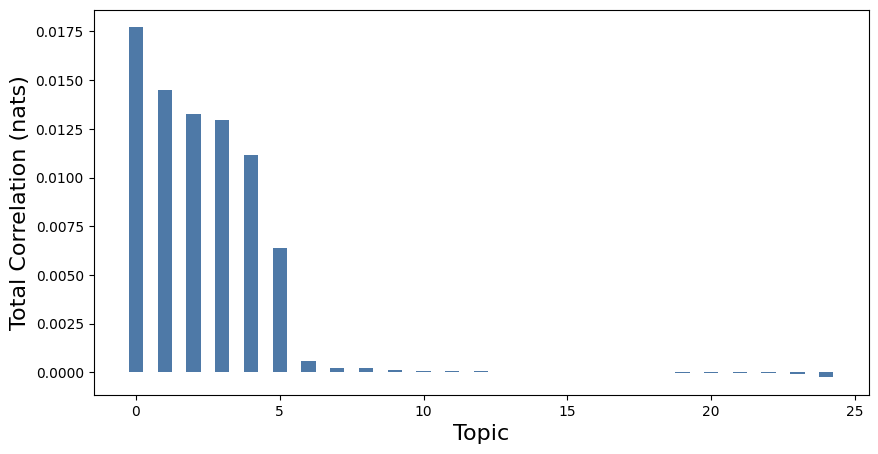

In [408]:
anchors = []
model = ct.Corex(n_hidden=25)
model = model.fit(tfidf_negative, words=vocab_negative)
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [409]:
topic_labels=[]
for i, topic_ngrams in enumerate(model.get_topics(n_words=10)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    print(f"Topic #{i+1}: {', '.join(topic_ngrams)}")
    topic_labels.append([i+1,', '.join(topic_ngrams)])

keywords_df_negative = pd.DataFrame(topic_labels, columns=['topic_num','keywords'])
keywords_df_negative['label'] = keywords_df_negative['keywords'].apply(lambda x: pd.Series(extract_theme(x)))
keywords_df_negative=keywords_df_negative[keywords_df_negative['label']!=''].reset_index()
keywords_df_negative

Topic #1: store, app store, amazon app, app, play store, google play, play, google, not available, available
Topic #2: lock screen, ads, lock, the lock, pop up, pop, the ads, ads on, that pop, annoying
Topic #3: price, better tablet, the price, especially for, find better, better, believe the, this price, believe, tablet for
Topic #4: figure out, figure, out how, out, right out, box, how to, pixels, with dead, to figure
Topic #5: camera, the camera, camera is, quality is, camera isn, quality, that great, great, you pay, the best
Topic #6: is the, only, the only, only downside, downside, only drawback, drawback is, downside is, drawback, complaint is
Topic #7: recommend, not recommend, to anyone, anyone, recommend this, wouldn recommend, recommend to, would not, wouldn
Topic #8: battery life, life, battery, life is, the battery, short, long
Topic #9: charging port, port, charging, stopped working, stopped, port is, working, within, the charging, month
Topic #10: parental controls, contr

,index,topic_num,keywords,label
0,0,1,"store, app store, amazon app, app, play store, google play, play, google, not available, available",not available
1,1,2,"lock screen, ads, lock, the lock, pop up, pop, the ads, ads on, that pop, annoying",lock screen
2,2,3,"price, better tablet, the price, especially for, find better, better, believe the, this price, believe, tablet for",especially for
3,3,4,"figure out, figure, out how, out, right out, box, how to, pixels, with dead, to figure",figure out
4,4,5,"camera, the camera, camera is, quality is, camera isn, quality, that great, great, you pay, the best",the camera
5,5,6,"is the, only, the only, only downside, downside, only drawback, drawback is, downside is, drawback, complaint is",only downside
6,6,7,"recommend, not recommend, to anyone, anyone, recommend this, wouldn recommend, recommend to, would not, wouldn",wouldn recommend
7,7,8,"battery life, life, battery, life is, the battery, short, long",battery life
8,8,9,"charging port, port, charging, stopped working, stopped, port is, working, within, the charging, month",stopped working
9,9,10,"parental controls, controls, parental",parental controls


In [410]:
anchor_df = data_sample_negative.copy().reset_index()
new_boolean = model.transform(tfidf_negative)[:,list(keywords_df_negative.topic_num-1)]
labeled_df_negative = pd.DataFrame(columns=['product','year','year_str','review','sentiment','label_num','label'])

for idx_row,row in enumerate(new_boolean):
    for idx_col,col in enumerate(row):
        if col:
            labeled_df_negative.loc[len(labeled_df_negative.index)] = [anchor_df['product'][idx_row],anchor_df['year'][idx_row],str(anchor_df['year'][idx_row]),anchor_df['review'][idx_row],
                                                     anchor_df['predef_sentiment'][idx_row],keywords_df_negative['topic_num'][idx_col],keywords_df_negative['label'][idx_col]]

labeled_df_negative

,product,year,year_str,review,sentiment,label_num,label
0,B018Y229OU,2016,2016,You won't find a better tablet for the price.,negative,3,especially for
1,B018Y229OU,2016,2016,The only drawback for me is the Amazon modified Android OS.,negative,6,only downside
2,B018Y229OU,2016,2016,Wouldn't recommend it though really.,negative,7,wouldn recommend
3,B018Y229OU,2016,2016,The only annoyance is the adds that pop up on the home screen.,negative,2,lock screen
4,B018Y229OU,2016,2016,Had to return the first due to a flaw creating an inability to connect to wifi.,negative,11,wi fi
5,B018Y229OU,2016,2016,"The display is below average, at best.",negative,5,the camera
6,B018Y229OU,2016,2016,And the Amazon App Store is a bit clunky.,negative,1,not available
7,B018Y229OU,2016,2016,The screen/resolution is pretty bad,negative,5,the camera
8,B018Y229OU,2016,2016,"It took a long time for the videos and pictures to show up because I wasn't connected to Wifi, and it didn't recognize any music files.",negative,11,wi fi
9,B018Y229OU,2016,2016,"Once I did connect it, it was annoying to see that ads were displayed on the Lock Screen.",negative,2,lock screen


In [411]:
labels_df = pd.concat([labeled_df_positive,labeled_df_neutral,labeled_df_negative])
labels_df

,product,year,year_str,review,sentiment,label_num,label
0,B018Y229OU,2016,2016,"Good basic tablet for checking email , web browsing , and reading ebooks.",positive,2,games and
1,B018Y229OU,2016,2016,I would strongly recommend buying it.,positive,5,definitely recommend
2,B018Y229OU,2016,2016,It's a great reader but also good for surfing the web.,positive,2,games and
3,B018Y229OU,2016,2016,"Easy to set up and use, plus the price was reasonable.",positive,4,very easy
4,B018Y229OU,2016,2016,I got this for my niece.,positive,1,bought this
...,...,...,...,...,...,...,...
449,B018Y229OU,2017,2017,Only thing is the charger doesnt stay in the port and battery doesnt last long,negative,6,only downside
450,B018Y229OU,2017,2017,"Love my watch bumper, but the tablet is so slow wouldn't recommend",negative,7,wouldn recommend
451,B018Y229OU,2017,2017,Too many ads.,negative,2,lock screen
452,B018Y229OU,2017,2017,The camera quality is horrible.,negative,5,the camera


In [412]:
with open(f'Reviews_{product_asin}_label_predef.pkl', 'wb') as f:
    pickle.dump(labels_df, f)
labels_df

,product,year,year_str,review,sentiment,label_num,label
0,B018Y229OU,2016,2016,"Good basic tablet for checking email , web browsing , and reading ebooks.",positive,2,games and
1,B018Y229OU,2016,2016,I would strongly recommend buying it.,positive,5,definitely recommend
2,B018Y229OU,2016,2016,It's a great reader but also good for surfing the web.,positive,2,games and
3,B018Y229OU,2016,2016,"Easy to set up and use, plus the price was reasonable.",positive,4,very easy
4,B018Y229OU,2016,2016,I got this for my niece.,positive,1,bought this
...,...,...,...,...,...,...,...
449,B018Y229OU,2017,2017,Only thing is the charger doesnt stay in the port and battery doesnt last long,negative,6,only downside
450,B018Y229OU,2017,2017,"Love my watch bumper, but the tablet is so slow wouldn't recommend",negative,7,wouldn recommend
451,B018Y229OU,2017,2017,Too many ads.,negative,2,lock screen
452,B018Y229OU,2017,2017,The camera quality is horrible.,negative,5,the camera
